In [15]:
# GPU 확인
!nvidia-smi

# 필요한 라이브러리 설치
!pip install efficientnet_pytorch

# 기본 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from efficientnet_pytorch import EfficientNet

# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Fri Nov  7 06:49:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             31W /   70W |    1940MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# Google Drive의 데이터셋 경로 확인
print("Google Drive 마운트 완료!")
print("\nColab Notebooks 폴더 내용:")
!ls -l /content/drive/MyDrive/Colab\ Notebooks/

# 데이터셋 압축 해제
import zipfile
import os

# Google Drive에서 압축 파일 경로
zip_path = '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data.zip'

# 압축 해제할 디렉토리
extract_path = '/content/hymenoptera_data'

# 압축 해제
print(f"\n압축 파일 해제 중: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("✓ 압축 해제 완료!")

# 데이터 디렉토리 확인
print("\n=== 데이터 구조 확인 ===")
!ls -l /content/hymenoptera_data/
print("\n=== Train 데이터 ===")
!ls -l /content/hymenoptera_data/train/
print("\n=== Val 데이터 ===")
!ls -l /content/hymenoptera_data/val/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료!

Colab Notebooks 폴더 내용:
total 85326
-rw------- 1 root root     3954 Sep 12 07:32  AI_Week2.ipynb
-rw------- 1 root root  3089540 Sep 19 03:39  AI_week3.ipynb
-rw------- 1 root root  2294693 Sep 25 13:15  AI_week4.ipynb
-rw------- 1 root root  1323794 Sep 25 08:34  AI.week4_practice.ipynb
-rw------- 1 root root  2039143 Oct  4 06:28  AI_week5.ipynb
-rw------- 1 root root   417395 Nov  3 11:07  AI_week6.ipynb
-rw------- 1 root root   120029 Sep 19 03:05  audio_dataset.zip
-rw------- 1 root root 47286322 Nov  7 06:42  hymenoptera_data.zip
-rw------- 1 root root   780087 Nov  3 11:20 'Lab-Computer Vision-01.ipynb'
-rw------- 1 root root  2706472 Nov  7 06:49 'LAB-Computer Vison-02.ipynb'
-rw------- 1 root root 27309237 Oct 30 06:07  sample_computer_vision.zip

압축 파일 해제 중: /content/drive/MyDrive/Colab Notebooks/hymenoptera_data.zip
✓ 압축 해제 완료!

In [17]:
# 데이터 전처리 및 증강
# EfficientNet은 기본적으로 224x224 입력 크기 사용
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # 추가 증강
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 추가 증강
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 로드
data_dir = '/content/hymenoptera_data'  # Google Drive에서 압축 해제한 경로
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

# 데이터로더 생성
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=16,  # EfficientNet에 적합한 배치 크기
        shuffle=True,
        num_workers=4
    )
    for x in ['train', 'val']
}

# 데이터셋 크기 및 클래스 정보
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f'Train 데이터셋 크기: {dataset_sizes["train"]}')
print(f'Validation 데이터셋 크기: {dataset_sizes["val"]}')
print(f'클래스: {class_names}')

Train 데이터셋 크기: 244
Validation 데이터셋 크기: 153
클래스: ['ants', 'bees']


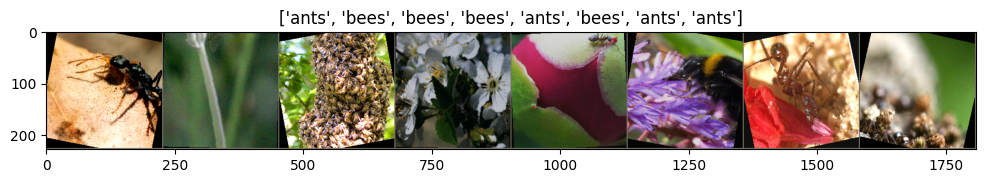

In [18]:
def imshow(inp, title=None):
    """Tensor 이미지를 표시하는 함수"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 학습 데이터 배치 가져오기
inputs, classes = next(iter(dataloaders['train']))

# 이미지 그리드 생성
out = torchvision.utils.make_grid(inputs[:8])

plt.figure(figsize=(12, 8))
imshow(out, title=[class_names[x] for x in classes[:8]])
plt.show()

In [19]:
def create_efficientnet_model(num_classes=2):
    """
    사전학습된 EfficientNet-B0 모델을 로드하고
    마지막 분류층을 수정하는 함수
    """
    # ImageNet으로 사전학습된 EfficientNet-B0 로드
    model = EfficientNet.from_pretrained('efficientnet-b0')

    # 마지막 분류층의 입력 특징 개수 확인
    num_ftrs = model._fc.in_features

    # 마지막 분류층을 새로운 층으로 교체 (2개 클래스)
    model._fc = nn.Linear(num_ftrs, num_classes)

    return model

# 모델 생성 및 GPU로 이동
model_ft = create_efficientnet_model(num_classes=2)
model_ft = model_ft.to(device)

print("EfficientNet-B0 모델 구조:")
print(f"마지막 분류층: {model_ft._fc}")

Loaded pretrained weights for efficientnet-b0
EfficientNet-B0 모델 구조:
마지막 분류층: Linear(in_features=1280, out_features=2, bias=True)


In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    모델 학습 함수
    - 학습률 스케줄링 적용
    - 최고 성능 모델 저장
    - 각 에포크별 Loss와 Accuracy 출력
    """
    since = time.time()

    # 최고 모델 가중치 저장용
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 학습 히스토리 저장
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        # 각 에포크는 학습 및 검증 단계를 가짐
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드
            else:
                model.eval()   # 평가 모드

            running_loss = 0.0
            running_corrects = 0

            # 데이터 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # Forward
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize (학습 단계에서만)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 학습률 스케줄러 업데이트
            if phase == 'train':
                scheduler.step()

            # 에포크 손실 및 정확도 계산
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # 히스토리 저장
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize():5s} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 최고 모델 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'*** 새로운 최고 검증 정확도: {best_acc:.4f} ***')

    time_elapsed = time.time() - since
    print('\n' + '=' * 60)
    print(f'학습 완료 시간: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'최고 검증 정확도: {best_acc:.4f}')
    print('=' * 60)

    # 최고 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    return model, history

In [21]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저: Adam 사용 (EfficientNet에 적합)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 학습률 스케줄러: 7 에포크마다 학습률을 0.1배로 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
# 모델 학습 (25 에포크)
print("=" * 60)
print("EfficientNet-B0 전이학습 시작")
print("=" * 60)

model_ft, history = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=5
)

# 학습된 모델 저장
torch.save(model_ft.state_dict(), 'efficientnet_hymenoptera_best.pth')
print("\n✓ 최고 성능 모델이 'efficientnet_hymenoptera_best.pth'로 저장되었습니다.")

EfficientNet-B0 전이학습 시작

Epoch 1/5
------------------------------------------------------------
Train Loss: 0.3860 Acc: 0.8074
Val   Loss: 0.2019 Acc: 0.9412
*** 새로운 최고 검증 정확도: 0.9412 ***

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.2100 Acc: 0.9180
Val   Loss: 2.3506 Acc: 0.7582

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.4213 Acc: 0.8525
Val   Loss: 0.3772 Acc: 0.8889

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.3377 Acc: 0.8770
Val   Loss: 0.2571 Acc: 0.9346

Epoch 5/5
------------------------------------------------------------
Train Loss: 0.2715 Acc: 0.8811
Val   Loss: 1.0996 Acc: 0.8366

학습 완료 시간: 0m 30s
최고 검증 정확도: 0.9412

✓ 최고 성능 모델이 'efficientnet_hymenoptera_best.pth'로 저장되었습니다.


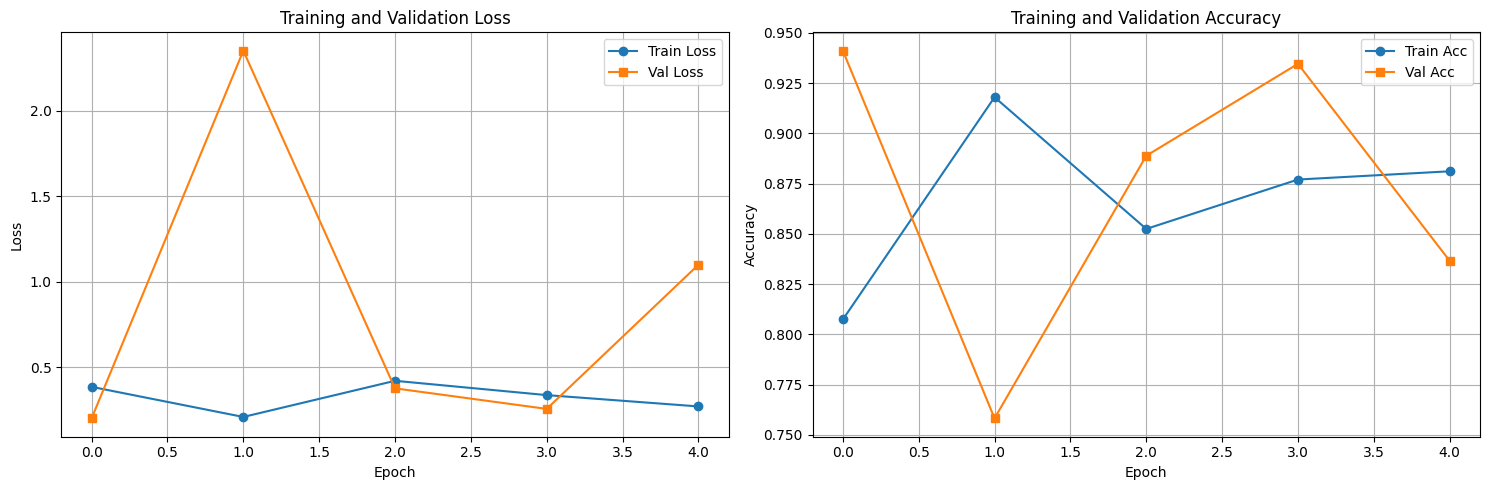


 최종 학습 결과:
   - 최종 Train Accuracy: 0.8811
   - 최종 Val Accuracy: 0.8366
   - 최고 Val Accuracy: 0.9412


In [23]:
def plot_training_history(history):
    """학습 히스토리를 시각화하는 함수"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss 그래프
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy 그래프
    ax2.plot(history['train_acc'], label='Train Acc', marker='o')
    ax2.plot(history['val_acc'], label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 최종 결과 출력
    print("\n 최종 학습 결과:")
    print(f"   - 최종 Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"   - 최종 Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"   - 최고 Val Accuracy: {max(history['val_acc']):.4f}")

# 학습 히스토리 시각화
plot_training_history(history)


 모델 예측 결과 시각화 (초록색: 정답, 빨간색: 오답)


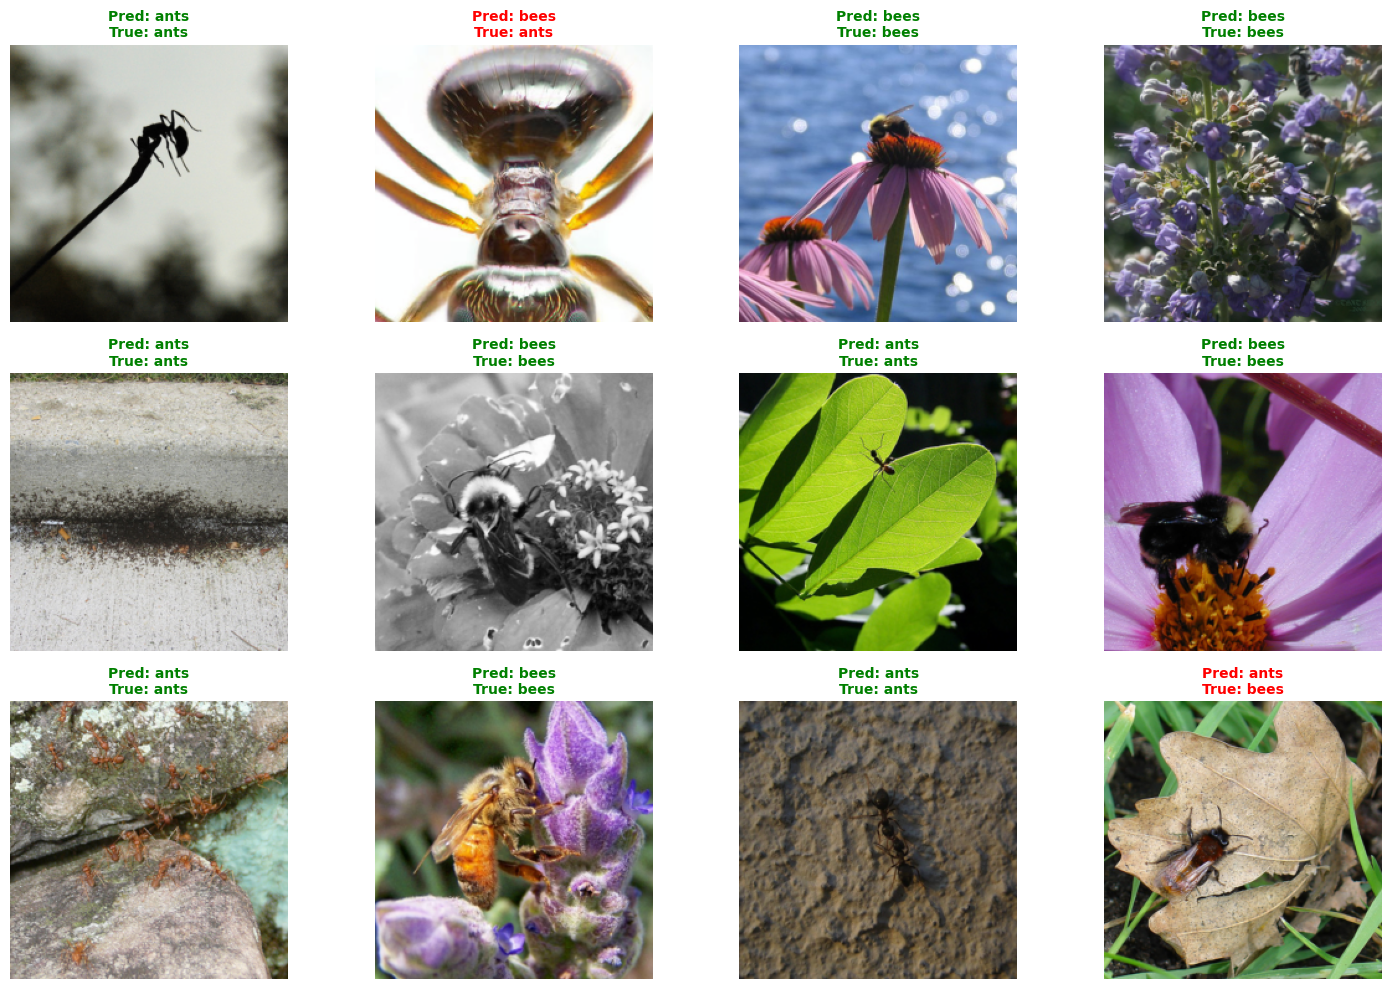

In [24]:
def visualize_model_predictions(model, num_images=12):
    """
    모델의 예측 결과를 시각화하는 함수
    """
    was_training = model.training
    model.eval()

    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(3, 4, images_so_far)
                ax.axis('off')

                # 예측 결과에 따라 색상 변경 (정답: 초록, 오답: 빨강)
                is_correct = preds[j] == labels[j]
                color = 'green' if is_correct else 'red'

                title = f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}'
                ax.set_title(title, color=color, fontsize=10, weight='bold')

                # 이미지 표시
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
                    plt.show()
                    return

        model.train(mode=was_training)

# 예측 결과 시각화
print("\n 모델 예측 결과 시각화 (초록색: 정답, 빨간색: 오답)")
visualize_model_predictions(model_ft, num_images=12)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


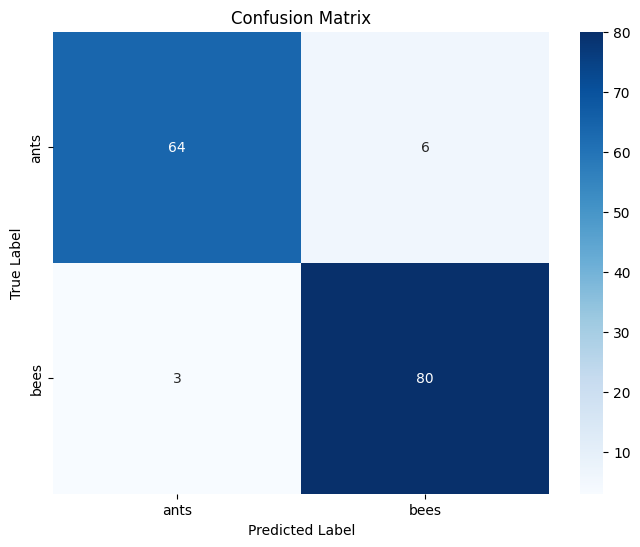


 분류 리포트:
              precision    recall  f1-score   support

        ants     0.9552    0.9143    0.9343        70
        bees     0.9302    0.9639    0.9467        83

    accuracy                         0.9412       153
   macro avg     0.9427    0.9391    0.9405       153
weighted avg     0.9417    0.9412    0.9411       153



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model):
    """모델 평가 및 혼동 행렬 생성"""
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬
    cm = confusion_matrix(all_labels, all_preds)

    # 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 분류 리포트
    print("\n 분류 리포트:")
    print(classification_report(all_labels, all_preds,
                                target_names=class_names, digits=4))

    return cm

# 모델 평가
cm = evaluate_model(model_ft)

/tmp/ipython-input-777960684.py:27: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-777960684.py:27: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-777960684.py:27: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-777960684.py:27: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-777960684.py:27: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


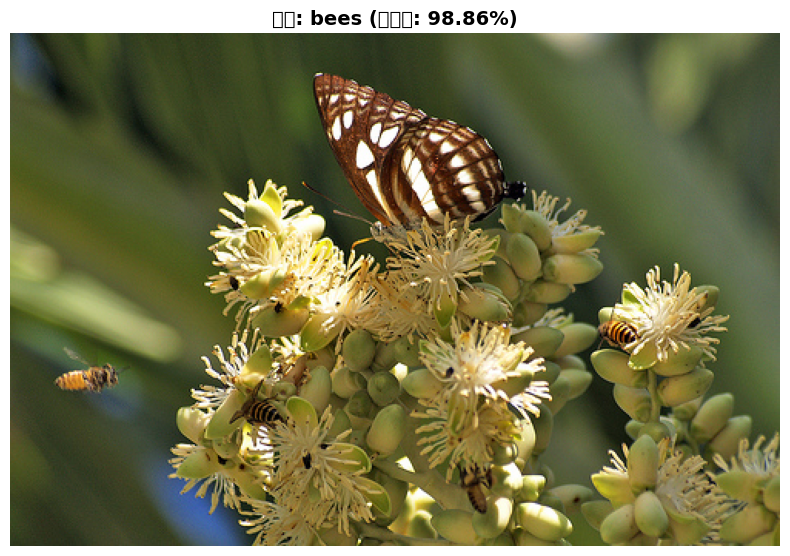


예측 결과:
  클래스: bees
  확신도: 98.86%

각 클래스별 확률:
  ants: 1.14%
  bees: 98.86%


In [29]:
def predict_single_image(model, img_path):
    """
    단일 이미지에 대한 예측을 수행하고 시각화
    """
    model.eval()

    # 이미지 로드 및 전처리
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms['val'](img).unsqueeze(0).to(device)

    # 예측
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, pred = torch.max(outputs, 1)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')

    pred_class = class_names[pred.item()]
    confidence = probs[0][pred.item()].item() * 100

    plt.title(f'예측: {pred_class} (확신도: {confidence:.2f}%)',
              fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n예측 결과:")
    print(f"  클래스: {pred_class}")
    print(f"  확신도: {confidence:.2f}%")
    print(f"\n각 클래스별 확률:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {probs[0][i].item() * 100:.2f}%")

# 예시: 검증 데이터셋의 특정 이미지 예측
sample_img_path = '/content/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
predict_single_image(model_ft, sample_img_path)